In [1]:
!pip install mlxtend networkx

In [2]:
# --- Celda de Imports para Modelado ---
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Para Reglas de Asociación
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
import networkx as nx

# Para Clustering
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler

# Configuraciones de visualización
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12

# --- Cargar los datos preprocesados ---
data_path = Path("data/processed_for_modeling")

# Datos para Reglas de Asociación
df_transactions = pd.read_parquet(data_path / "transactions_matrix.parquet")

# Datos para Clustering de Tracks
tracks_for_clustering = pd.read_parquet(data_path / "tracks_for_clustering.parquet")
tracks_umap = pd.read_parquet(data_path / "tracks_umap_embedding.parquet")

# DataFrame completo para agregación a nivel de playlist
df_processed = pd.read_parquet(data_path / "df_processed_full.parquet")

print("Datos cargados exitosamente.")
print(f"Matriz de transacciones shape: {df_transactions.shape}")
print(f"DataFrame para clustering de tracks shape: {tracks_for_clustering.shape}")

Datos cargados exitosamente.
Matriz de transacciones shape: (9000, 66243)
DataFrame para clustering de tracks shape: (66243, 126)


In [3]:
import pandas as pd
from pathlib import Path

# # --- Cargar los datos preprocesados ---
# data_path = Path("data/processed_for_modeling")
# df_transactions = pd.read_parquet(data_path / "transactions_matrix.parquet")

print("--- Paso de Optimización de Memoria ---")

# 1. Medir el uso de memoria ANTES de la optimización
# El .memory_usage() devuelve el uso por columna, .sum() lo totaliza.
# Lo dividimos por 1024*1024 para mostrarlo en Megabytes (MB).
mem_usage_before = df_transactions.memory_usage(deep=True).sum() / 1024**2
print(f"Tipo de dato original: {df_transactions.dtypes.iloc[0]}")
print(f"Uso de memoria ANTES de la optimización: {mem_usage_before:.2f} MB")

# 2. Aplicar la optimización convirtiendo el tipo de dato a 'bool'
# bool es el tipo de dato más eficiente para valores binarios (True/False, 1/0).
df_transactions_opt = df_transactions.astype('bool')

# 3. Medir el uso de memoria DESPUÉS de la optimización
mem_usage_after = df_transactions_opt.memory_usage(deep=True).sum() / 1024**2
print(f"\nTipo de dato optimizado: {df_transactions_opt.dtypes.iloc[0]}")
print(f"Uso de memoria DESPUÉS de la optimización: {mem_usage_after:.2f} MB")

# 4. Calcular y mostrar la reducción
reduction_pct = (1 - mem_usage_after / mem_usage_before) * 100
print(f"\nReducción de memoria: {reduction_pct:.1f}%")

print("\n¡Optimización completada! Ahora puedes usar 'df_transactions_opt' en la función Apriori.")

--- Paso de Optimización de Memoria ---
Tipo de dato original: int64
Uso de memoria ANTES de la optimización: 4548.61 MB

Tipo de dato optimizado: bool
Uso de memoria DESPUÉS de la optimización: 568.64 MB

Reducción de memoria: 87.5%

¡Optimización completada! Ahora puedes usar 'df_transactions_opt' en la función Apriori.


# 4: Reglas de Asociación
Usaremos la matriz df_transactions para descubrir qué canciones tienden a aparecer juntas en las mismas playlists.

# 4.1 Aplicar Algoritmos (Apriori y FP-Growth)
Ambos algoritmos buscan conjuntos de ítems (canciones) frecuentes. La diferencia principal es su rendimiento; FP-Growth suele ser más rápido.

El hiperparámetro clave aquí es min_support (soporte mínimo). Define la frecuencia mínima que debe tener un conjunto de canciones para ser considerado "frecuente". Un valor bajo encontrará más reglas pero tardará más. Empecemos con 0.005 (presente en al menos el 0.5% de las playlists)

In [4]:
# --- 4.1 Búsqueda de Ítems Frecuentes ---

# Hiperparámetro a ajustar
MIN_SUPPORT = 0.005

# --- Algoritmo 1: Apriori ---
print("Ejecutando Apriori...")

# use_colnames=True para que los resultados muestren los track_id en lugar de índices de columna
frequent_itemsets_apriori = apriori(df_transactions_opt, min_support=MIN_SUPPORT, use_colnames=True)
print(f"Apriori encontró {len(frequent_itemsets_apriori)} conjuntos de ítems frecuentes.")


# --- Algoritmo 2: FP-Growth (generalmente más rápido) ---
print("\nEjecutando FP-Growth...")
frequent_itemsets_fpgrowth = fpgrowth(df_transactions, min_support=MIN_SUPPORT, use_colnames=True)
print(f"FP-Growth encontró {len(frequent_itemsets_fpgrowth)} conjuntos de ítems frecuentes.")

# Mostramos los 10 más frecuentes encontrados por FP-Growth
print("\nTop 10 conjuntos de ítems más frecuentes:")
frequent_itemsets_fpgrowth.sort_values(by='support', ascending=False).head(10)

Ejecutando Apriori...
Apriori encontró 1062 conjuntos de ítems frecuentes.

Ejecutando FP-Growth...


/home/faes/Escritorio/2025-1/mineriaDatos/Proyecto/SpotifyProyect/venv/lib/python3.12/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


FP-Growth encontró 1062 conjuntos de ítems frecuentes.

Top 10 conjuntos de ítems más frecuentes:


,support,itemsets
80,0.024778,(7yyRTcZmCiyzzJlNzGC9Ol)
53,0.024000,(5dNfHmqgr128gMY2tc5CeJ)
81,0.023667,(5XJJdNPkwmbUwE79gv0NxK)
554,0.023444,(62vpWI1CHwFy7tMIcSStl8)
82,0.022778,(7BKLCZ1jbUBVqRi2FVlTVw)
658,0.022222,(7KXjTSCq5nL1LoYtL7XAwS)
473,0.021778,(27GmP9AWRs744SzKcpJsTZ)
472,0.021778,(0v9Wz8o0BT8DU38R4ddjeH)
21,0.021444,(1xznGGDReH1oQq0xzbwXa3)
120,0.020111,(5hTpBe8h35rJ67eAWHQsJx)


In [5]:
#codigo para mostrar en la terminal las caracterisiticas del RAM y CPU disponible
import psutil

# Mostrar características de la CPU
print("Características de la CPU:")
print(f"Núcleos: {psutil.cpu_count(logical=False)}")
print(f"Frecuencia: {psutil.cpu_freq().current} MHz")

# Mostrar características de la RAM
print("\nCaracterísticas de la RAM:")
print(f"Total: {psutil.virtual_memory().total / (1024 ** 3):.2f} GB")

Características de la CPU:
Núcleos: 6
Frecuencia: 3734.3281666666667 MHz

Características de la RAM:
Total: 31.16 GB


# 4.2 Generar y Analizar Reglas de Asociación
A partir de los conjuntos frecuentes, generamos las reglas. Nos interesan principalmente dos métricas:

Confianza (Confidence): La probabilidad de encontrar el item B si ya tienes el item A.
Lift: Mide cuánto más probable es encontrar B si tienes A, en comparación con la probabilidad de encontrar B por sí solo. Un lift > 1 indica una asociación positiva.

In [6]:
# --- 4.2 Generación de Reglas ---

# Usaremos los itemsets de FP-Growth que es más eficiente
# Generamos las reglas con un umbral mínimo de confianza de 0.1 (10%)
rules = association_rules(frequent_itemsets_fpgrowth, metric="confidence", min_threshold=0.1)

# Filtramos y ordenamos las reglas para encontrar las más interesantes
# Un lift > 1.5 y una confianza > 0.2 suelen ser un buen punto de partida
significant_rules = rules[(rules['lift'] > 1.5) & (rules['confidence'] > 0.2)]
significant_rules = significant_rules.sort_values(by="lift", ascending=False).reset_index(drop=True)

print(f"Se generaron {len(rules)} reglas en total.")
print(f"Se encontraron {len(significant_rules)} reglas significativas después de filtrar.")

# Mostramos las 5 reglas más fuertes
print("\nTop 5 reglas de asociación más significativas (ordenadas por lift):")
significant_rules.head()

Se generaron 104 reglas en total.
Se encontraron 104 reglas significativas después de filtrar.

Top 5 reglas de asociación más significativas (ordenadas por lift):


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(5kjyiH6but1t2UDXq15aeS),(1yEwEiTpsaPhQi9lb5EVV4),0.010444,0.010889,0.006222,0.595745,54.711246,1.0,0.006108,2.446749,0.992084,0.411765,0.591294,0.583587
1,(1yEwEiTpsaPhQi9lb5EVV4),(5kjyiH6but1t2UDXq15aeS),0.010889,0.010444,0.006222,0.571429,54.711246,1.0,0.006108,2.308963,0.992530,0.411765,0.566905,0.583587
2,(6fwdbPMwP1zVStm8FybmkO),(4gmmRb6bZJffOOiww1JGTO),0.014111,0.008111,0.005444,0.385827,47.567684,1.0,0.005330,1.614999,0.992990,0.324503,0.380804,0.528530
3,(4gmmRb6bZJffOOiww1JGTO),(6fwdbPMwP1zVStm8FybmkO),0.008111,0.014111,0.005444,0.671233,47.567684,1.0,0.005330,2.998745,0.986983,0.324503,0.666527,0.528530
4,(4dGJf1SER1T6ooX46vwzRB),(5kjyiH6but1t2UDXq15aeS),0.013889,0.010444,0.006667,0.480000,45.957447,1.0,0.006522,1.902991,0.992019,0.377358,0.474512,0.559149


# 4.3 Entregables (CSV y Gráfico de Red)


Reglas guardadas en 'data/results/reglas_asociacion_significativas.csv'


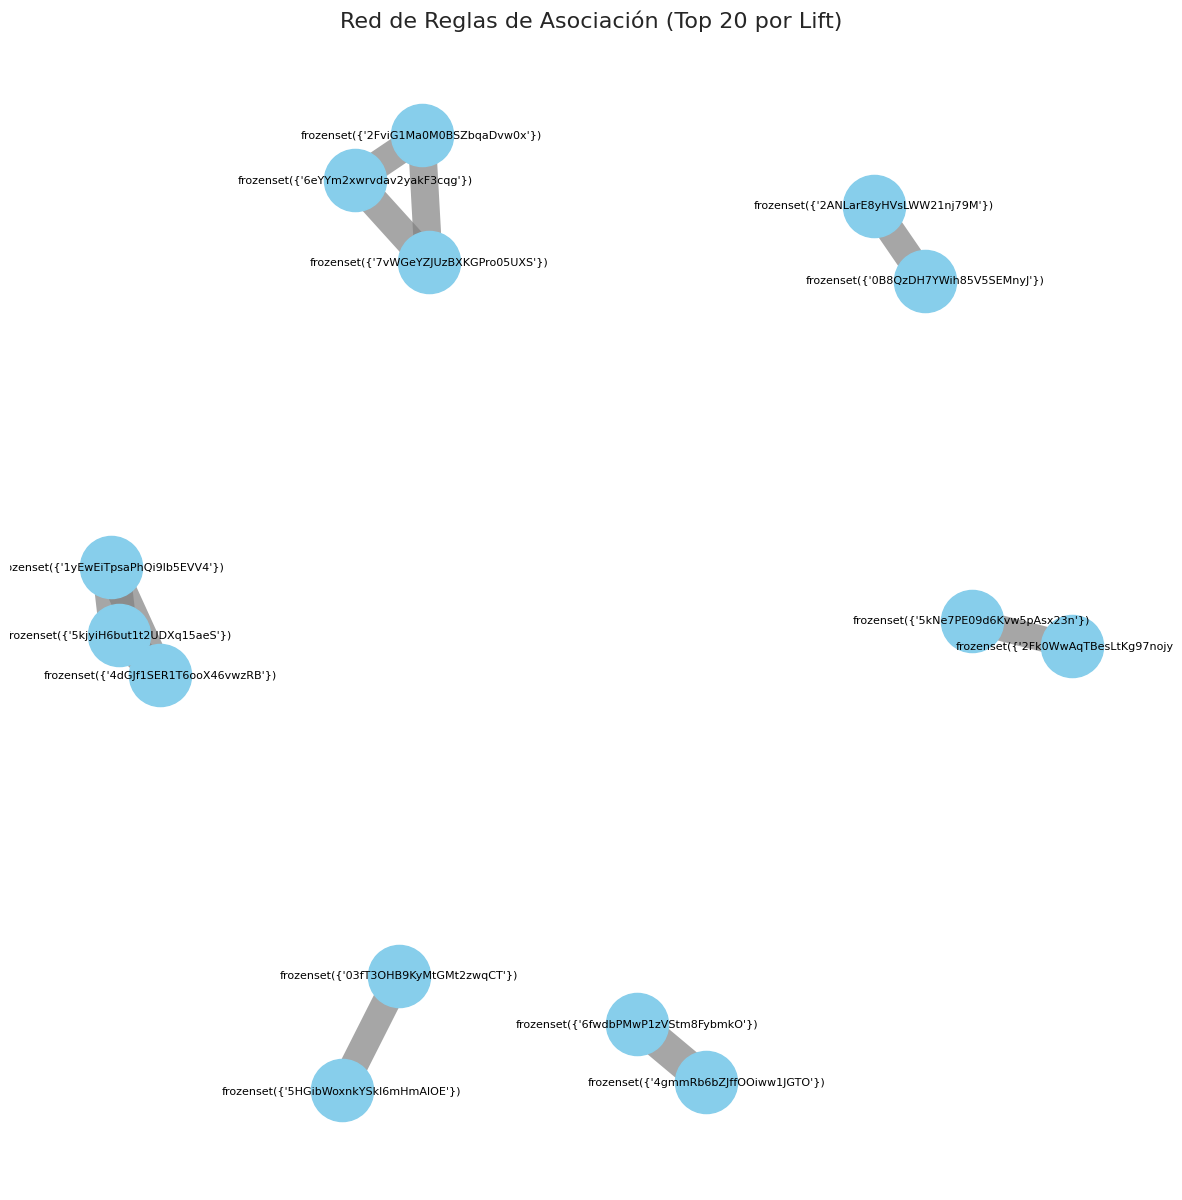

In [7]:
# --- 4.3 Entregables ---

# 1. Guardar las reglas en un archivo CSV
rules_output_path = Path("data/results")
rules_output_path.mkdir(parents=True, exist_ok=True)
significant_rules.to_csv(rules_output_path / "reglas_asociacion_significativas.csv", index=False)
print(f"Reglas guardadas en '{rules_output_path / 'reglas_asociacion_significativas.csv'}'")


# 2. Visualización: Gráfico de Red de las 20 reglas principales
# (Puede ser lento si hay muchas reglas)
top_rules = significant_rules.head(20)

plt.figure(figsize=(15, 15))
G = nx.from_pandas_edgelist(top_rules,
                           source='antecedents',
                           target='consequents',
                           edge_attr=['lift', 'confidence'])

# Posiciones de los nodos
pos = nx.spring_layout(G, k=0.5, iterations=50)

# Dibujar nodos y etiquetas
nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
nx.draw_networkx_labels(G, pos, font_size=8)

# Dibujar aristas con grosor basado en el lift
edge_width = [d['lift'] * 0.5 for (u, v, d) in G.edges(data=True)]
nx.draw_networkx_edges(G, pos, width=edge_width, edge_color='gray', alpha=0.7)

plt.title('Red de Reglas de Asociación (Top 20 por Lift)')
plt.axis('off')
plt.show()

# 5: Clustering (Agrupación)
Dividiremos esta sección en dos partes, como se discutió: clustering de tracks y de playlists.

**Parte A: Clustering a Nivel de Canción (Track)**

Usaremos tracks_for_clustering para agrupar canciones con características de audio similares.

## 5.A.1 Algoritmo 1: K-Means con Búsqueda de K Óptimo

Shape original de X_tracks: (66243, 126)
Shape de X_tracks_numeric (solo columnas numéricas): (66243, 97)



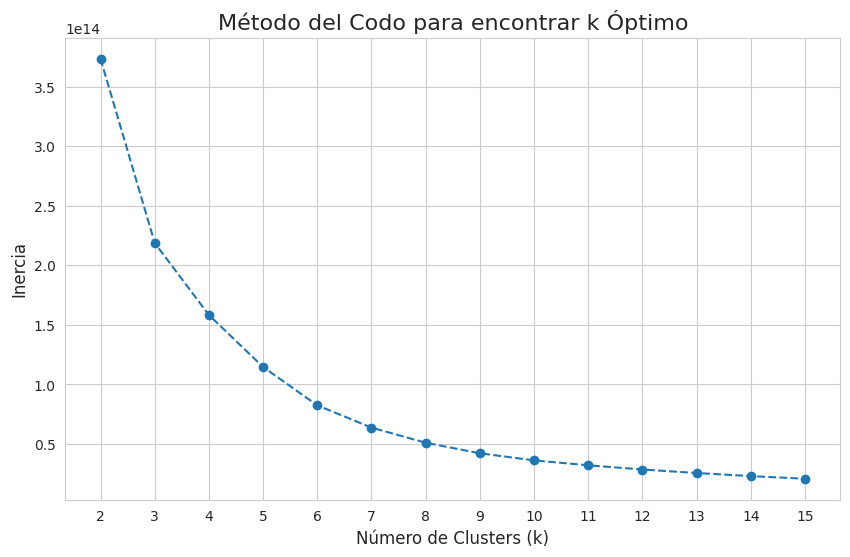


Clustering con K-Means completado usando k=8.


In [8]:
# --- 5.A.1 K-Means (Versión Corregida) ---
# Usamos el método del codo (Elbow Method) para encontrar un buen valor para k

X_tracks = tracks_for_clustering.copy() # Datos de entrada originales

# --- LA CORRECCIÓN ESTÁ AQUÍ ---
# K-Means solo puede trabajar con números. Nos aseguramos de seleccionar solo las columnas numéricas.
# El error 'could not convert string to float: 'Party'' indica que columnas de texto se colaron.
X_tracks_numeric = X_tracks.select_dtypes(include=np.number)

print(f"Shape original de X_tracks: {X_tracks.shape}")
print(f"Shape de X_tracks_numeric (solo columnas numéricas): {X_tracks_numeric.shape}\n")


# --- Continuación del código original, usando el DataFrame NUMÉRICO ---
inertia = []
K_range = range(2, 16) # Probaremos con k de 2 a 15

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    # Usamos el DataFrame NUMÉRICO para el ajuste
    kmeans.fit(X_tracks_numeric)
    inertia.append(kmeans.inertia_)

# Graficar el codo
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo para encontrar k Óptimo')
plt.xticks(K_range)
plt.show()

# Basado en el gráfico, elegimos un valor para k (ej. k=8 donde la curva se aplana)
OPTIMAL_K = 8
kmeans = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)
# Usamos el DataFrame NUMÉRICO aquí también
track_labels_kmeans = kmeans.fit_predict(X_tracks_numeric)

print(f"\nClustering con K-Means completado usando k={OPTIMAL_K}.")

## 5.A.2 Algoritmos 2 y 3: DBSCAN y Agglomerative Clustering


In [ ]:
# --- 5.A.2 Algoritmos 2 y 3: DBSCAN y Agglomerative Clustering (CORREGIDO) ---

# --- DBSCAN ---
# DBSCAN es bueno para encontrar clusters de formas arbitrarias y detectar ruido (outliers)
# Sus hiperparámetros (eps, min_samples) son sensibles y requieren ajuste fino.
print("Ejecutando DBSCAN...")
dbscan = DBSCAN(eps=2.5, min_samples=15) # Estos valores son un punto de partida
# LA CORRECCIÓN: Usamos X_tracks_numeric, no X_tracks
track_labels_dbscan = dbscan.fit_predict(X_tracks_numeric)
print("DBSCAN completado.")

# --- Agglomerative Clustering ---
# Crea una jerarquía de clusters.
print("Ejecutando Agglomerative Clustering...")
agglomerative = AgglomerativeClustering(n_clusters=OPTIMAL_K) # Usamos el mismo k que en KMeans
# LA CORRECCIÓN: Usamos X_tracks_numeric, no X_tracks
track_labels_agglomerative = agglomerative.fit_predict(X_tracks_numeric)
print("Agglomerative Clustering completado.")


# --- 5.A.3 Evaluación Comparativa y Visualización (CORREGIDO) ---
print("\nCalculando métricas de evaluación...")

# K-Means (ya lo tenías, pero lo incluimos para la tabla comparativa)
score_s_kmeans = silhouette_score(X_tracks_numeric, track_labels_kmeans)
score_db_kmeans = davies_bouldin_score(X_tracks_numeric, track_labels_kmeans)

# DBSCAN (excluyendo ruido y usando el DataFrame numérico)
mask_dbscan = track_labels_dbscan != -1
# Nos aseguramos de que haya más de 1 clúster para poder evaluar
if len(set(track_labels_dbscan[mask_dbscan])) > 1:
    score_s_dbscan = silhouette_score(X_tracks_numeric[mask_dbscan], track_labels_dbscan[mask_dbscan])
    score_db_dbscan = davies_bouldin_score(X_tracks_numeric[mask_dbscan], track_labels_dbscan[mask_dbscan])
else:
    score_s_dbscan = -1 # Valor inválido si no hay suficientes clusters
    score_db_dbscan = -1

# Agglomerative (usando el DataFrame numérico)
score_s_agg = silhouette_score(X_tracks_numeric, track_labels_agglomerative)
score_db_agg = davies_bouldin_score(X_tracks_numeric, track_labels_agglomerative)


# Crear tabla de resultados
results = pd.DataFrame({
    'Algoritmo': ['K-Means', 'DBSCAN', 'Agglomerative'],
    'Silhouette Score (más alto es mejor)': [score_s_kmeans, score_s_dbscan, score_s_agg],
    'Davies-Bouldin Score (más bajo es mejor)': [score_db_kmeans, score_db_dbscan, score_db_agg]
})

print("\n--- Tabla Comparativa de Modelos de Clustering de Tracks ---")
display(results)


# --- Visualización de Clusters (usando los resultados de K-Means como ejemplo) ---
viz_df = tracks_umap.copy()
viz_df['cluster'] = track_labels_kmeans

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=viz_df,
    x='UMAP_1',
    y='UMAP_2',
    hue='cluster',
    palette=sns.color_palette("hsv", n_colors=OPTIMAL_K),
    s=10,
    alpha=0.7,
    legend='full'
)
plt.title(f'Visualización de Clusters de Canciones (K-Means, k={OPTIMAL_K})')
plt.show()


Ejecutando DBSCAN...
DBSCAN completado.
Ejecutando Agglomerative Clustering...


In [ ]:
# --- 5.A.2 Algoritmos 2 y 3: DBSCAN y MiniBatchKMeans (CORREGIDO Y OPTIMIZADO) ---

# --- DBSCAN ---
# DBSCAN puede ser lento en datasets grandes. Sus hiperparámetros son clave.
# Si esta parte también es muy lenta, considera ejecutarla sobre una muestra o ajustar 'eps'.
print("Ejecutando DBSCAN...")
dbscan = DBSCAN(eps=2.5, min_samples=20, n_jobs=-1) # n_jobs=-1 usa todos los núcleos de tu CPU
track_labels_dbscan = dbscan.fit_predict(X_tracks_numeric)
print("DBSCAN completado.")


# --- MiniBatchKMeans (Reemplazo eficiente para Agglomerative Clustering) ---
# Este algoritmo es mucho más rápido y consume muchísima menos memoria.
print("Ejecutando MiniBatchKMeans...")
mini_batch_kmeans = MiniBatchKMeans(
    n_clusters=OPTIMAL_K, # Usamos el mismo k que en KMeans
    random_state=42,
    batch_size=256, # Tamaño del lote, un hiperparámetro a ajustar
    n_init=10
)
track_labels_minibatch = mini_batch_kmeans.fit_predict(X_tracks_numeric)
print("MiniBatchKMeans completado.")


# --- 5.A.3 Evaluación Comparativa y Visualización (CORREGIDO) ---
print("\nCalculando métricas de evaluación...")

# K-Means
score_s_kmeans = silhouette_score(X_tracks_numeric, track_labels_kmeans)
score_db_kmeans = davies_bouldin_score(X_tracks_numeric, track_labels_kmeans)

# DBSCAN (excluyendo ruido)
mask_dbscan = track_labels_dbscan != -1
if len(set(track_labels_dbscan[mask_dbscan])) > 1:
    # Usamos una muestra para el cálculo del score si es muy lento
    sample_indices = np.random.choice(X_tracks_numeric[mask_dbscan].index, size=min(20000, len(X_tracks_numeric[mask_dbscan])), replace=False)
    score_s_dbscan = silhouette_score(X_tracks_numeric.loc[sample_indices], track_labels_dbscan[mask_dbscan][sample_indices])
    score_db_dbscan = davies_bouldin_score(X_tracks_numeric.loc[sample_indices], track_labels_dbscan[mask_dbscan][sample_indices])
else:
    score_s_dbscan, score_db_dbscan = -1, -1

# MiniBatchKMeans
score_s_minibatch = silhouette_score(X_tracks_numeric, track_labels_minibatch)
score_db_minibatch = davies_bouldin_score(X_tracks_numeric, track_labels_minibatch)


# Crear tabla de resultados
results = pd.DataFrame({
    'Algoritmo': ['K-Means', 'DBSCAN', 'MiniBatchKMeans'],
    'Silhouette Score (más alto es mejor)': [score_s_kmeans, score_s_dbscan, score_s_minibatch],
    'Davies-Bouldin Score (más bajo es mejor)': [score_db_kmeans, score_db_dbscan, score_db_minibatch]
})

print("\n--- Tabla Comparativa de Modelos de Clustering de Tracks ---")
display(results)

# (El código de visualización que ya tenías funcionará igual)
# ...

# 5.A.3 Evaluación Comparativa y Visualización


In [ ]:
# --- 5.A.3 Evaluación Interna ---
# Calculamos Silhouette y Davies-Bouldin para los modelos
# Nota: Para DBSCAN, excluimos los puntos de ruido (label -1) de la evaluación

# K-Means
score_s_kmeans = silhouette_score(X_tracks, track_labels_kmeans)
score_db_kmeans = davies_bouldin_score(X_tracks, track_labels_kmeans)

# DBSCAN (excluyendo ruido)
mask_dbscan = track_labels_dbscan != -1
score_s_dbscan = silhouette_score(X_tracks[mask_dbscan], track_labels_dbscan[mask_dbscan])
score_db_dbscan = davies_bouldin_score(X_tracks[mask_dbscan], track_labels_dbscan[mask_dbscan])

# Agglomerative
score_s_agg = silhouette_score(X_tracks, track_labels_agglomerative)
score_db_agg = davies_bouldin_score(X_tracks, track_labels_agglomerative)


# Crear tabla de resultados
results = pd.DataFrame({
    'Algoritmo': ['K-Means', 'DBSCAN', 'Agglomerative'],
    'Silhouette Score (más alto es mejor)': [score_s_kmeans, score_s_dbscan, score_s_agg],
    'Davies-Bouldin Score (más bajo es mejor)': [score_db_kmeans, score_db_dbscan, score_db_agg]
})

print("--- Tabla Comparativa de Modelos de Clustering de Tracks ---")
print(results)


# --- Visualización de Clusters (usando los resultados de K-Means como ejemplo) ---
# Usamos el UMAP que precalculamos en el notebook anterior
viz_df = tracks_umap.copy()
viz_df['cluster'] = track_labels_kmeans

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=viz_df,
    x='UMAP_1',
    y='UMAP_2',
    hue='cluster',
    palette=sns.color_palette("hsv", n_colors=OPTIMAL_K),
    s=10,
    alpha=0.7,
    legend='full'
)
plt.title(f'Visualización de Clusters de Canciones (K-Means, k={OPTIMAL_K})')
plt.show()

**Parte B: Clustering a Nivel de Playlist**

Aquí realizamos el paso de agregación que faltaba (nivel de playlists)

## 5.B.1 Preparar Vectores de Features de Playlists


In [ ]:
# --- 5.B.1 Agregación a Nivel de Playlist ---

# Seleccionar columnas numéricas de audio
numerical_cols = tracks_for_clustering.columns

# Agrupar por playlist (pid) y calcular la media de las características de sus canciones
playlist_features_df = df_processed.groupby('pid')[numerical_cols].mean()

# ¡Importante! Debemos escalar estas nuevas features agregadas también.
scaler_playlist = MinMaxScaler()
playlist_features_scaled = scaler_playlist.fit_transform(playlist_features_df)
playlist_features_scaled_df = pd.DataFrame(playlist_features_scaled, index=playlist_features_df.index, columns=playlist_features_df.columns)


print("DataFrame para clustering de playlists creado y escalado.")
playlist_features_scaled_df.head()

## 5.B.2 Aplicar Clustering y Visualizar con Gráfico Radar
Aplicaremos K-Means como ejemplo y crearemos el gráfico radar para interpretar los clusters.

In [ ]:
# --- 5.B.2 K-Means para Playlists y Gráfico Radar ---

# Usaremos un k diferente, por ejemplo k=6 para playlists
K_PLAYLISTS = 6
kmeans_playlist = KMeans(n_clusters=K_PLAYLISTS, random_state=42, n_init=10)
playlist_labels = kmeans_playlist.fit_predict(playlist_features_scaled_df)

# Añadir las etiquetas de cluster al dataframe escalado
playlist_features_scaled_df['cluster'] = playlist_labels


# --- Gráfico Radar para interpretar los clusters ---
# Calculamos los centroides (el perfil promedio de cada cluster)
centroids = playlist_features_scaled_df.groupby('cluster').mean()

# Preparar para el gráfico
labels = centroids.columns
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1] # Repetir el primer ángulo para cerrar el círculo

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

for i, row in centroids.iterrows():
    values = row.values.flatten().tolist()
    values += values[:1] # Repetir el primer valor
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=f'Cluster {i}')
    ax.fill(angles, values, alpha=0.1)

ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
plt.title('Perfil Promedio de Clusters de Playlists (Gráfico Radar)', size=20, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()